# Fusing bayesian optimization explorations at different sample sizes

In [22]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import Matern, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors, cm 

from math import log, floor, sqrt

copper = mpl.cm.copper 
cNorm  = colors.Normalize(vmin=-0.9, vmax=-0.25)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=copper)

Utilities to compute time allocation

In [23]:
def cost_per_model(pct, algo='svm'): 
    x = [i for i in range(1,101, 1)] 
 
    if algo == 'rf': 
        nlogn = [i*log(i) for i in x]
        return nlogn[99]/nlogn[int(pct*100) - 1]
    if algo == 'svm':
        n_n = [i*i for i in x]
        return n_n[99]/n_n[int(pct*100) - 1] 
    


def budget_division(budget, how='equal', steps=3, lower=0.4):
    
    def normalizing_factor(lst, budget):
        '''sum(lst).X = budget'''
        return budget / sum(lst)
    
    if how == 'equal':
        return [int(budget/steps) for _ in range(steps)]
    else:
        slices = [budget/(1+s) for s in range(steps)]
        norm_factor = normalizing_factor(slices, budget)
        normalized_slices = [norm_factor*s for s in slices]
        
        if how == 'linear_asc':
            return normalized_slices
        if how == 'linear_desc':
            return normalized_slices[::-1]
        

def models_at_sample_size(budget, sample_size, algo):
    return int(budget*cost_per_model(sample_size, algo))


def size(i, lower=0.4, steps=3):
    #i += 1
    return lower + i * (1 - lower)/(steps - 1)

Data generation

In [24]:
def get_data():
    """Synthetic binary classification dataset."""
    data, targets = make_classification(
        n_samples=5_000,
        n_features=22,
        n_informative=12,
        n_redundant=4, 
        random_state=0,
    )
    return data, targets

Function to optimize: random forest classifier being score with negative log loss.

In [25]:
def rfc_cv(n_estimators, min_samples_split, max_features, data, targets): 
    estimator = RFC(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        max_features=max_features,
        random_state=2
    ) 
    
    cval = cross_val_score(estimator, data, targets,
                           scoring='neg_log_loss', cv=3)
    return cval.mean()
 

In [51]:
# points to probe in next level. 
#Something dynamic like sqrt(observations) could do the job but needs additional control mechanisms.
n_points = 5

from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)
def points_to_probe(optimizer):
    x0_obs = np.array([[res["params"]["max_features"]] for res in optimizer.res]) 
    x1_obs = np.array([[res["params"]["min_samples_split"]] for res in optimizer.res])
    x2_obs = np.array([[res["params"]["n_estimators"]] for res in optimizer.res]) 
    y_obs = np.array([res["target"] for res in optimizer.res]) 
     

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]: 
        ax.scatter(x0_obs, x1_obs, x2_obs, c=scalarMap.to_rgba(y_obs), alpha=0.5)

    ax.set_xlabel('max_features')
    ax.set_ylabel('min_samples_split')
    ax.set_zlabel('n_estimators')
    plt.colorbar(scalarMap)
    plt.tight_layout()
    plt.show()
        
    #plt.matshow(optimizer._gp.L_)
    #plt.title('Lower-triangular Cholesky decomposition of cov')
    #plt.show() 
    
    idx = y_obs.argsort()[-n_points:][::-1]
    probe = [[x0_obs[i], x1_obs[i], x2_obs[i]] for i in idx]
    
    return probe



def optimize_rfc(data, targets, level, cov_function_prior, n_iter=0, bounds=None, to_probe=None):
    """
    level: index + 1 of sample size in [pct0, pct1, .. pctN].
    cov_function_prior: definition of cov. function by the gaussian process regression. It's going to be updated every step.
    n_iter: number of models to be computed at each sample size. Is constrained by the total budget.
    bounds: updated boundaries for hyper param. space.
    to_probe: promissing points found in smaller sample sizes.
    
    
    """
    def rfc_crossval(n_estimators, min_samples_split, max_features): 
        return rfc_cv(
            n_estimators=int(n_estimators),
            min_samples_split=float(min_samples_split),
            max_features=max(min(max_features, 0.999), 1e-3), 
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=rfc_crossval,
        pbounds={
            "n_estimators": (10, 250),
            "min_samples_split": (0.01, 0.999),
            "max_features": (0.1, 0.999), 
        },
        random_state=1234,
        verbose=1
    ) 
    
    # model noise in each sample size (level)
    optimizer._gp.kernel = cov_function_prior + WhiteKernel(noise_level=0.01/(level + 1))
     
    if len(to_probe) > 0:
        for point in to_probe: 
            optimizer.probe(
                params=point,
                lazy=True,
                )
    
    # control structure to constrain compute budget
    if level == 1:
        init_points = 2 # minimum amount of points to start inference -> randomly generated.
    else:
        init_points = 0
    n_iter -= n_points 
        
    optimizer.maximize(init_points=init_points, n_iter=n_iter, acq="ucb", kappa=3) 
    
    #print(Colours.yellow(f'Prior kernel: {optimizer._gp.kernel}'))
    #print(Colours.purple(f'Posterior kernel: {optimizer._gp.kernel_}'))
    
    cov_function_posterior = optimizer._gp.kernel_

    return points_to_probe(optimizer), cov_function_posterior

--- Optimizing Random Forest: 100 models; budget: 100 --- 
|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  4        | -0.3423   |  0.4902   |  0.02077  |  10.02    |
|  5        | -0.3404   |  0.999    |  0.01     |  10.0     |
|  6        | -0.3149   |  0.9771   |  0.01587  |  188.5    |
|  12       | -0.2959   |  0.999    |  0.01     |  96.31    |
|  16       | -0.2946   |  0.999    |  0.01     |  141.4    |
|  51       | -0.2943   |  0.999    |  0.01     |  122.7    |
|  95       | -0.2942   |  0.999    |  0.01     |  126.5    |


<Figure size 432x288 with 0 Axes>

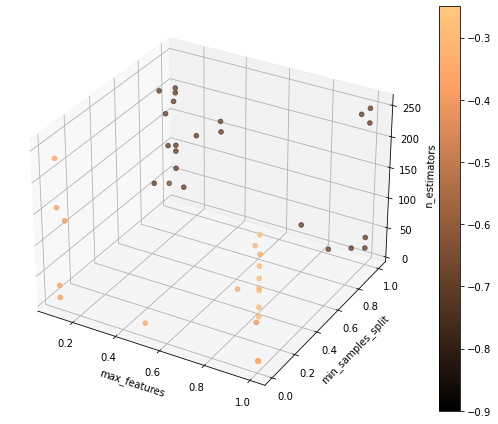

--- Optimizing Random Forest: 100 models; budget: 100 --- 
|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  2        | -0.2939   |  0.999    |  0.01     |  122.7    |
|  3        | -0.2935   |  0.999    |  0.01     |  141.4    |
|  4        | -0.2931   |  0.999    |  0.01     |  208.6    |
|  54       | -0.293    |  0.999    |  0.01     |  189.1    |
|  89       | -0.293    |  0.999    |  0.01     |  192.9    |


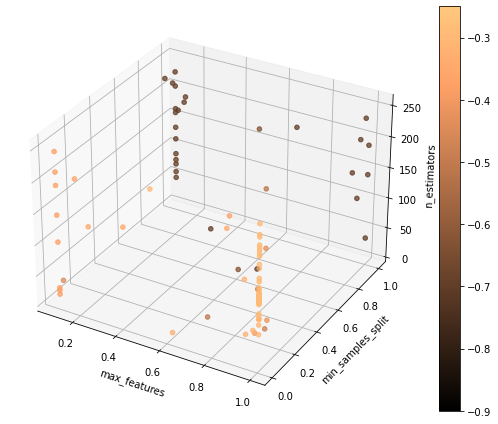

In [52]:
data, targets = get_data()

lower = 1
steps = 2
budget = 200

bounds = None
to_probe = []
cov_function_prior = Matern(nu=2.5) + WhiteKernel(noise_level=0.01)

plt.figure()
for level, b in enumerate(budget_division(budget, how='equal', steps=steps, lower=lower)):
    sample_size = size(level, lower, steps) 
    n_iter = models_at_sample_size(b, sample_size, 'rf')
    
    rows = int(len(data) * sample_size)
    idx = np.random.choice(len(data), rows, replace=False)
    sampled_X = data[idx,:]
    sampled_y = targets[idx]

    print(Colours.green(f"--- Optimizing Random Forest: {n_iter} models; budget: {b} --- "))
    to_probe, cov_function_posterior = optimize_rfc(sampled_X, sampled_y, level + 1, cov_function_prior, n_iter, bounds, to_probe)
    
    cov_function_prior = cov_function_posterior 
     
